<a href="https://colab.research.google.com/github/kimdesok/Physical_AI_PINN/blob/main/Intro_to_Physical_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Simplified 1D Heat Equation

In [15]:
import torch
import torch.nn as nn

# A simple standard Neural Network
class HeatNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 1)
        )
    def forward(self, x):
        return self.net(x)

# The loss term that should be zero while training
def physics_loss(model, x):
    x.requires_grad = True
    u = model(x)

    # Calculate the gradient (how temperature changes over distance)
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]

    # Calculate the second gradient (curvature of temperature)
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]


    # In a steady state, the change should follow thermal conductivity.
    # We want the physics error to equal zero.
    physics_error = u_xx - 0.5 * u  # 0.5 represents cooling to air

    return torch.mean(physics_error**2)

In [16]:
# Training Loop
model = HeatNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(1000):
    optimizer.zero_grad()

    # We just give it random points (x) - NO LABELS NEEDED!
    x_random = torch.rand(100, 1)

    loss = physics_loss(model, x_random) # Penalize if it breaks physics
    loss.backward()
    optimizer.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch}: Physics Error = {loss.item():.6f}")

Epoch 0: Physics Error = 0.003596
Epoch 200: Physics Error = 0.000000
Epoch 400: Physics Error = 0.000000
Epoch 600: Physics Error = 0.000000
Epoch 800: Physics Error = 0.000000


# Another one with the time variable

In [17]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# The Neural Network
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 1)
        )
    def forward(self, x, t):
        return self.net(torch.cat([x, t], dim=1))

# Setup data (Generating the 'Unit Tests')
def generate_data():
    # PDE points: random locations in the rod (0-1) and time (0-1)
    x_pde = torch.rand(2000, 1, requires_grad=True)
    t_pde = torch.rand(2000, 1, requires_grad=True)

    # Boundary condition: Left end (x=0) and right end (x=1) are kept at 0°C (coolant water)
    x_bc = torch.cat([torch.zeros(100, 1), torch.ones(100, 1)], dim=0)
    t_bc = torch.rand(200, 1)
    u_bc = torch.zeros(200, 1)

    # Initial condition: At t=0, the rod is hot (100°C) everywhere
    x_ic = torch.rand(500, 1)
    t_ic = torch.zeros(500, 1)
    u_ic = torch.ones(500, 1) # Normalized heat

    return x_pde, t_pde, x_bc, t_bc, u_bc, x_ic, t_ic, u_ic

## The Core PINN Logic
- Assumes the water does not flow along the hot rod

In [4]:
def still_water_train():
    model = PINN()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    x_pde, t_pde, x_bc, t_bc, u_bc, x_ic, t_ic, u_ic = generate_data()
    alpha = 0.1 # Diffusivity

    for epoch in range(3001):
        optimizer.zero_grad()

        # --- PDE Loss ---
        u = model(x_pde, t_pde)
        u_t = torch.autograd.grad(u, t_pde, torch.ones_like(u), create_graph=True)[0]
        u_x = torch.autograd.grad(u, x_pde, torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x_pde, torch.ones_like(u_x), create_graph=True)[0]
        loss_pde = torch.mean((u_t - alpha * u_xx)**2)

        # --- Boundary/Initial Loss ---
        loss_bc = torch.mean((model(x_bc, t_bc) - u_bc)**2)
        loss_ic = torch.mean((model(x_ic, t_ic) - u_ic)**2)

        total_loss = loss_pde + loss_bc + loss_ic
        total_loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch} | Loss: {total_loss.item():.6f}")

    return model

# Train the model that represents a case of stationary water
model = still_water_train()

Epoch 0 | Loss: 0.675137
Epoch 500 | Loss: 0.086374
Epoch 1000 | Loss: 0.049683
Epoch 1500 | Loss: 0.032062
Epoch 2000 | Loss: 0.028298
Epoch 2500 | Loss: 0.026030
Epoch 3000 | Loss: 0.024191


# Visualize the result



In [5]:
def plot_temp(model, title):
  x = np.linspace(0, 1, 100)
  t = np.linspace(0, 1, 100)
  X, T = np.meshgrid(x, t)
  x_flat = torch.tensor(X.flatten()[:, None], dtype=torch.float32)
  t_flat = torch.tensor(T.flatten()[:, None], dtype=torch.float32)

  u_pred = model(x_flat, t_flat).detach().numpy().reshape(100, 100)

  plt.imshow(u_pred, extent=[0, 1, 0, 1], origin='lower', aspect='auto', cmap='hot')
  plt.colorbar(label='Temperature')
  plt.xlabel('Position (x)')
  plt.ylabel('Time (t)')
  plt.title(title)
  plt.show()

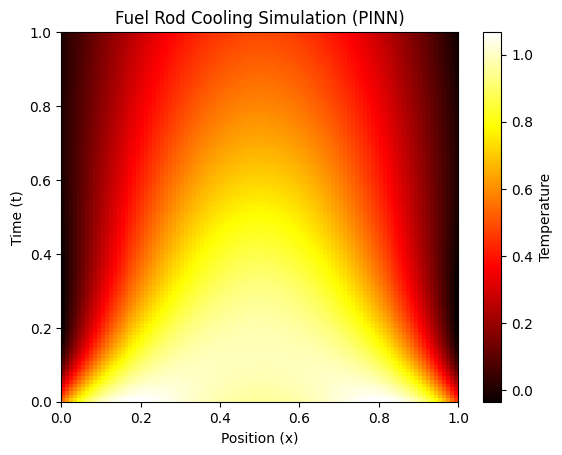

In [6]:
# Visualize the temperature change over time
plot_temp(model, "Fuel Rod Cooling Simulation (PINN)")

## Now simulates the coolant water flowing along the rod (a fuel rod in the reactor or something).

In [7]:
def flow_water_train(v):
    #v - Velocity of the coolant water flowing from x=0 to x=1
    model = PINN()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    x_pde, t_pde, x_bc, t_bc, u_bc, x_ic, t_ic, u_ic = generate_data()
    alpha = 0.1 # Diffusivity

    for epoch in range(3001):
        optimizer.zero_grad()

        # --- PDE Loss ---
        u = model(x_pde, t_pde)
        # Physics Error including the "push" of the water (Advection)
        # u_t: change over time
        # v * u_x: heat being carried away by the moving water
        # alpha * u_xx: heat spreading through the metal itself

        u_t = torch.autograd.grad(u, t_pde, torch.ones_like(u), create_graph=True)[0]
        u_x = torch.autograd.grad(u, x_pde, torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x_pde, torch.ones_like(u_x), create_graph=True)[0]

        physics_error = u_t + v * u_x - alpha * u_xx
        loss_pde = torch.mean(physics_error**2)

        # --- Boundary/Initial Loss ---
        loss_bc = torch.mean((model(x_bc, t_bc) - u_bc)**2)
        loss_ic = torch.mean((model(x_ic, t_ic) - u_ic)**2)

        total_loss = loss_pde + loss_bc + loss_ic
        total_loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch} | Loss: {total_loss.item():.6f}")

    return model

# Run and Plot
model = flow_water_train(v=0.5)

Epoch 0 | Loss: 1.008998
Epoch 500 | Loss: 0.101093
Epoch 1000 | Loss: 0.040127
Epoch 1500 | Loss: 0.026001
Epoch 2000 | Loss: 0.020915
Epoch 2500 | Loss: 0.018431
Epoch 3000 | Loss: 0.016722


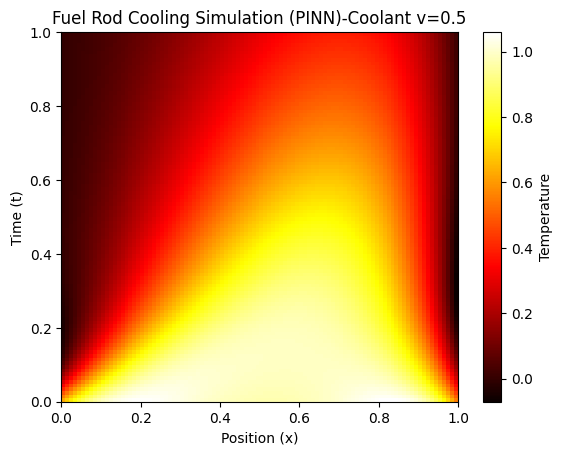

In [8]:
# Visualize the result
plot_temp(model, "Fuel Rod Cooling Simulation (PINN)-Coolant v=0.5")

Epoch 0 | Loss: 0.901707
Epoch 500 | Loss: 0.203647
Epoch 1000 | Loss: 0.045838
Epoch 1500 | Loss: 0.029746
Epoch 2000 | Loss: 0.026281
Epoch 2500 | Loss: 0.024229
Epoch 3000 | Loss: 0.022955


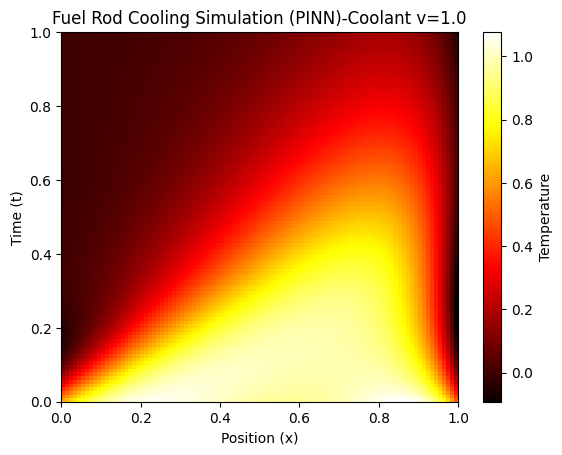

In [9]:
model = flow_water_train(v=1.0)
plot_temp(model, "Fuel Rod Cooling Simulation (PINN)-Coolant v=1.0")

## An improved network with the velocity as an added variable

In [10]:
class ParametricHeatNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Input is now 3: [position, time, velocity]
        self.net = nn.Sequential(
            nn.Linear(3, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x, t, v):
        # We stack all three into one vector
        return self.net(torch.cat([x, t, v], dim=1))

In [11]:
def flow_water_velocity_train():
    model = ParametricHeatNet()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    x_pde, t_pde, x_bc, t_bc, u_bc, x_ic, t_ic, u_ic = generate_data()

    # v_pde must match x_pde (2000 rows)
    v_pde = torch.rand(2000, 1) * 5.0

    # v_bc must match x_bc (200 rows)
    v_bc = torch.rand(200,1) * 50

    # v_ic must match x_ic (500 rows)
    v_ic = torch.rand(500,1) * 50

    alpha = 0.01 # Diffusivity

    for epoch in range(3001):
        optimizer.zero_grad()

        # --- PDE Loss ---
        u = model(x_pde, t_pde, v_pde)
        # New Physics Error including the "push" of the water (Advection)
        # u_t: change over time
        # v * u_x: heat being carried away by the moving water
        # alpha * u_xx: heat spreading through the metal itself

        u_t = torch.autograd.grad(u, t_pde, torch.ones_like(u), create_graph=True)[0]
        u_x = torch.autograd.grad(u, x_pde, torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x_pde, torch.ones_like(u_x), create_graph=True)[0]

        physics_error = u_t + v_pde * u_x - alpha * u_xx
        loss_pde = torch.mean(physics_error**2)

        #loss_pde = torch.mean((u_t - alpha * u_xx)**2)

        # --- Boundary/Initial Loss ---
        loss_bc = torch.mean((model(x_bc, t_bc, v_bc) - u_bc)**2)
        loss_ic = torch.mean((model(x_ic, t_ic, v_ic) - u_ic)**2)

        total_loss = loss_pde + loss_bc + loss_ic
        total_loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch} | Loss: {total_loss.item():.6f}")

    return model

# Run and Plot
model = flow_water_velocity_train()

Epoch 0 | Loss: 0.540159
Epoch 500 | Loss: 0.131709
Epoch 1000 | Loss: 0.070629
Epoch 1500 | Loss: 0.061326
Epoch 2000 | Loss: 0.055321
Epoch 2500 | Loss: 0.049703
Epoch 3000 | Loss: 0.044612


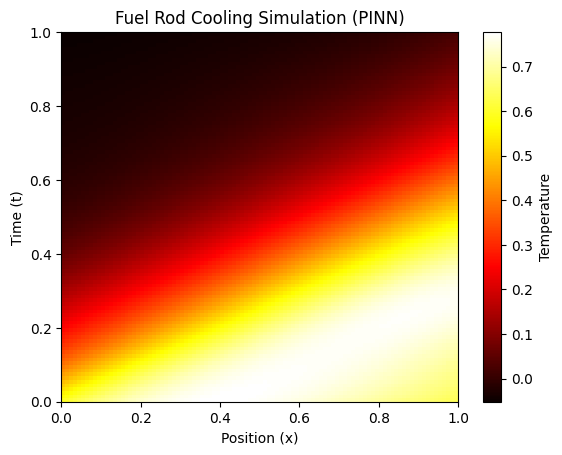

In [12]:
# --- In the Training Loop ---
# Visualize the result
x = np.linspace(0, 1, 100)
t = np.linspace(0, 1, 100)
X, T = np.meshgrid(x, t)
x_flat = torch.tensor(X.flatten()[:, None], dtype=torch.float32)
t_flat = torch.tensor(T.flatten()[:, None], dtype=torch.float32)

# To plot for a specific velocity (e.g., v=2.0)
v_plot = torch.ones_like(x_flat) * 2.0

u_pred = model(x_flat, t_flat, v_plot).detach().numpy().reshape(100, 100)

plt.imshow(u_pred, extent=[0, 1, 0, 1], origin='lower', aspect='auto', cmap='hot')
plt.colorbar(label='Temperature')
plt.xlabel('Position (x)')
plt.ylabel('Time (t)')
plt.title('Fuel Rod Cooling Simulation (PINN)')
plt.show()

In [13]:
import matplotlib.animation as animation
from IPython.display import HTML

# Setup the Mesh for plotting
x_plot = np.linspace(0, 1, 100)
t_plot = np.linspace(0, 1, 100)
X, T = np.meshgrid(x_plot, t_plot)
x_flat = torch.tensor(X.flatten()[:, None], dtype=torch.float32)
t_flat = torch.tensor(T.flatten()[:, None], dtype=torch.float32)

velocities_failure = np.linspace(0.5, 1.5, 20)
print(velocities_failure)

[0.5        0.55263158 0.60526316 0.65789474 0.71052632 0.76315789
 0.81578947 0.86842105 0.92105263 0.97368421 1.02631579 1.07894737
 1.13157895 1.18421053 1.23684211 1.28947368 1.34210526 1.39473684
 1.44736842 1.5       ]


In [14]:
# Animation Function: This "slides" the velocity

fig, ax = plt.subplots(figsize=(8, 4))

def update(v_val):
    ax.clear()

    # Create a constant velocity tensor for the whole grid
    v_plot = torch.ones_like(x_flat) * v_val

    # INFERENCE: Ask the brain "What does it look like at THIS speed?"
    with torch.no_grad():
        u_pred = model(x_flat, t_flat, v_plot).numpy().reshape(100, 100)

    im = ax.imshow(u_pred, extent=[0, 1, 0, 1], origin='lower', aspect='auto', cmap='magma')
    ax.set_title(f"Coolant Velocity: {v_val:.2f} m/s")
    ax.set_xlabel("Position along Rod (x)")
    ax.set_ylabel("Time (t)")
    return [im]

# Create the Frames (from 0 to 10 m/s)
ani = animation.FuncAnimation(fig, update, frames=velocities_failure, interval=100)

# Display in Colab
plt.close() # Prevents extra static plot from showing
HTML(ani.to_jshtml())